Mounted at /content/drive


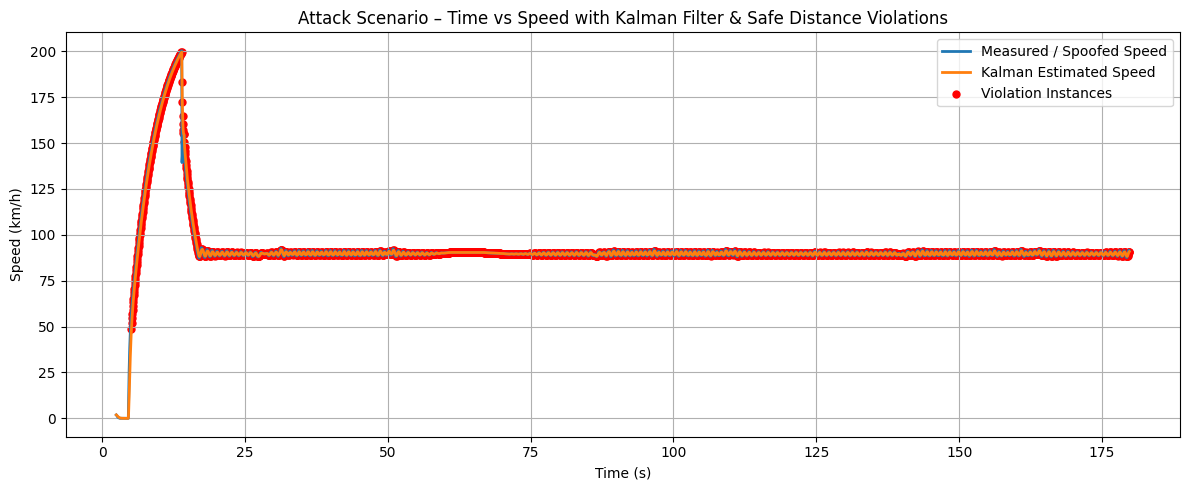

In [1]:
# =============================================
# ATTACK ONLY — KF APPLIED — VIOLATION MARKED
# =============================================

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------------------
# Paper Parameters (Eq. 8)
# -------------------------------
HEADWAY = 2.0    # seconds (h)
A_DECEL = 3.4    # m/s^2 (a)

DATA_PATH = "/content/drive/MyDrive/acc"
attack_file = "acc20220924-152419.csv"   # <-- confirmed attack run

# -------------------------------
# Standard 1D Kalman Filter (paper Sec 2.1)
# -------------------------------
def kalman_filter(z, Q=0.05, R=0.5):
    n = len(z)
    x = np.zeros(n)      # state estimate vh
    P = np.zeros(n)      # covariance

    # initialization
    x[0] = z[0]
    P[0] = 1.0

    for t in range(1, n):
        # prediction
        x_pred = x[t-1]
        P_pred = P[t-1] + Q

        # Kalman Gain
        K = P_pred / (P_pred + R)

        # update
        x[t] = x_pred + K * (z[t] - x_pred)
        P[t] = (1 - K) * P_pred

    return x

# -------------------------------
# Load & Process Attack Run
# -------------------------------
df = pd.read_csv(os.path.join(DATA_PATH, attack_file))

t = df["timestamp"].values

# host speed (m/s) -> convert to km/h for Eq. 8
vh = df["ego_vehicle_v"].values * 3.6

# apply Kalman Filter
vh_kf = kalman_filter(vh)

# compute gap distance
ego = df[["ego_vehicle_x","ego_vehicle_y","ego_vehicle_z"]].values
lead = df[["leader_vehicle_x","leader_vehicle_y","leader_vehicle_z"]].values
gap = np.linalg.norm(lead - ego, axis=1)

# safe distance (Eq. 8)
dsafe = 0.278 * HEADWAY * vh_kf + 0.039 * (vh_kf**2) / A_DECEL

# violation when gap < dsafe
violation = gap < dsafe

# -------------------------------
# Plot
# -------------------------------
plt.figure(figsize=(12,5))

plt.plot(t, vh, label="Measured / Spoofed Speed", linewidth=2)
plt.plot(t, vh_kf, label="Kalman Estimated Speed", linewidth=2)

# mark violations
plt.scatter(t[violation], vh_kf[violation],
            color="red", s=25, label="Violation Instances")

plt.xlabel("Time (s)")
plt.ylabel("Speed (km/h)")
plt.title("Attack Scenario – Time vs Speed with Kalman Filter & Safe Distance Violations")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


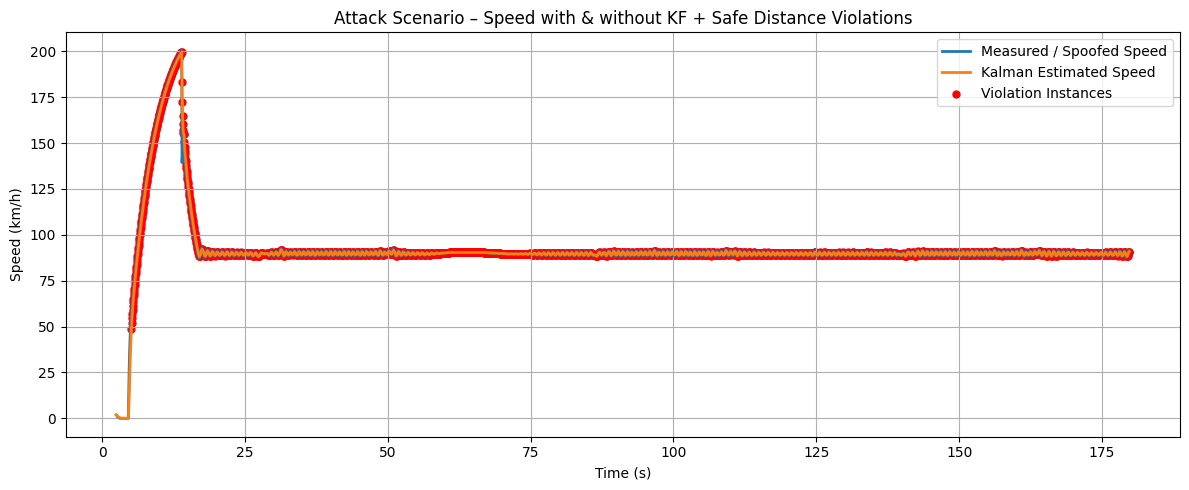

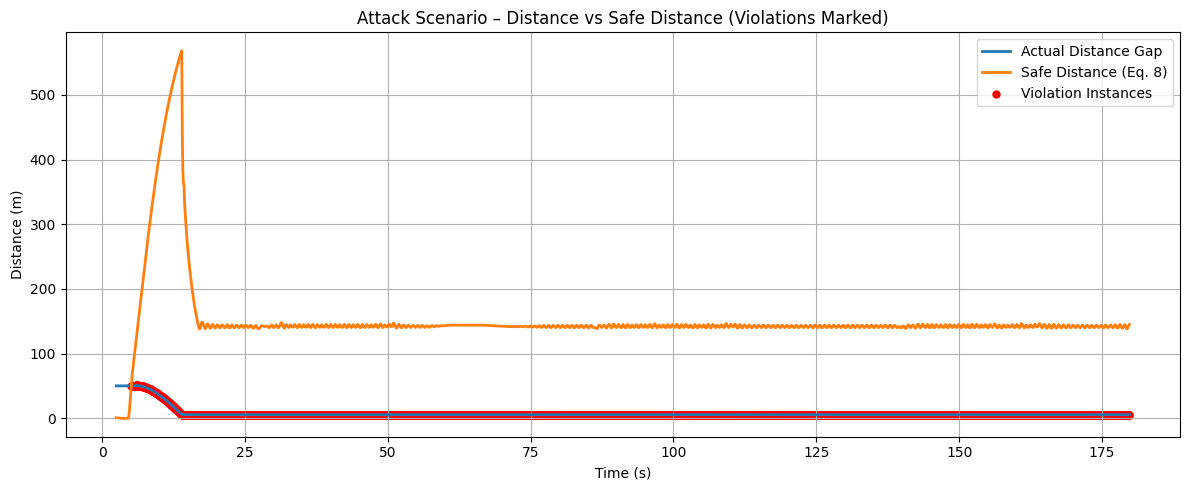

In [2]:
# =============================================
# ATTACK ONLY
# Show Speed w/ KF and w/o KF + Mark Violations
# Also show Gap vs Safe Distance + Violations
# =============================================

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------------------
# Paper Parameters (Eq. 8)
# -------------------------------
HEADWAY = 2.0    # seconds (h)
A_DECEL = 3.4    # m/s^2 (a)

DATA_PATH = "/content/drive/MyDrive/acc"
attack_file = "acc20220924-152419.csv"   # <-- confirmed attack dataset

# -------------------------------
# Standard 1D Kalman Filter (Paper Sec 2.1)
# -------------------------------
def kalman_filter(z, Q=0.05, R=0.5):
    n = len(z)
    x = np.zeros(n)
    P = np.zeros(n)

    x[0] = z[0]
    P[0] = 1.0

    for t in range(1, n):
        # prediction
        x_pred = x[t-1]
        P_pred = P[t-1] + Q

        # Kalman gain
        K = P_pred / (P_pred + R)

        # update
        x[t] = x_pred + K * (z[t] - x_pred)
        P[t] = (1 - K) * P_pred

    return x

# -------------------------------
# Load Attack Dataset
# -------------------------------
df = pd.read_csv(os.path.join(DATA_PATH, attack_file))

t = df["timestamp"].values

# Speed signals
vh_meas = df["ego_vehicle_v"].values * 3.6   # m/s -> km/h
vh_kf = kalman_filter(vh_meas)

# Distance gap
ego = df[["ego_vehicle_x","ego_vehicle_y","ego_vehicle_z"]].values
lead = df[["leader_vehicle_x","leader_vehicle_y","leader_vehicle_z"]].values
gap = np.linalg.norm(lead - ego, axis=1)

# Safe distance (Eq. 8)
dsafe = 0.278 * HEADWAY * vh_kf + 0.039 * (vh_kf**2) / A_DECEL

# violation condition
violation = gap < dsafe

# =============================================
# FIGURE 1 — Time vs Speed (KF + Non KF + Violations)
# =============================================
plt.figure(figsize=(12,5))

plt.plot(t, vh_meas, label="Measured / Spoofed Speed", linewidth=2)
plt.plot(t, vh_kf, label="Kalman Estimated Speed", linewidth=2)

plt.scatter(t[violation], vh_kf[violation],
            color="red", s=25, label="Violation Instances")

plt.xlabel("Time (s)")
plt.ylabel("Speed (km/h)")
plt.title("Attack Scenario – Speed with & without KF + Safe Distance Violations")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# =============================================
# FIGURE 2 — Gap vs Safe Distance + Violations
# =============================================
plt.figure(figsize=(12,5))

plt.plot(t, gap, label="Actual Distance Gap", linewidth=2)
plt.plot(t, dsafe, label="Safe Distance (Eq. 8)", linewidth=2)

plt.scatter(t[violation], gap[violation],
            color="red", s=25, label="Violation Instances")

plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.title("Attack Scenario – Distance vs Safe Distance (Violations Marked)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
